In [1]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = "4"  # Set the number of threads you prefer

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
# import dvc.api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Display max column
pd.set_option('display.max_columns', None)
## Display max rows
# pd.set_option('display.max_rows', None)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle # Read and Save model - Serialization
from datetime import datetime

# custom functions
import sys
sys.path.append(r"C:\Users\Admin\AI COURSE DIGICROME\Pharmaceutical Sales prediction across multiple stores")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
#Logger
log = logging.getLogger()
log.info('check')

INFO:root:check


## Preprocessing

In [3]:
train_store_file = 'train_store_merged.csv'

In [4]:
## loading merged train,store data using pandas library
train_store_df = pd.read_csv(train_store_file,parse_dates = True, low_memory = False)
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [5]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   Year                       1017209 non-null  int64  
 10  Month                      1017209 non-null  int64  
 11  Day                        1017209 non-null  int64  
 12  WeekOfYear                 1017209 non-null  int64  
 13  SalePerCusto

In [6]:
## Convert the 'Date' column to datetime format
train_store_df['Date'] = pd.to_datetime(train_store_df['Date'])

In [7]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   Year                       1017209 non-null  int64         
 10  Month                      1017209 non-null  int64         
 11  Day                        1017209 no

In [8]:
## columns to use
#columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
#       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']

# Label Date and StateHoliday Train
columns = ['Sales', 'Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day', 'WeekOfYear', 
           'Month', 'Year', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2']

feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Day', 'WeekOfYear', 
                   'Month', 'Year', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2']

sample_size = 1000
sampled_df = train_store_df[columns].sample(sample_size)

# Separate Test and Train files
train_x = sampled_df[feature_columns]
train_y = sampled_df[['Sales']]
train_x.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,WeekOfYear,Month,Year,StoreType,Assortment,CompetitionDistance,Promo2
3952,5,3,1,1,0,28,5,1,2015,a,a,29910.0,0
731990,804,4,1,0,0,25,26,6,2015,c,c,2100.0,1
930291,1020,5,1,0,1,4,1,1,2013,a,a,40.0,0
409882,450,1,1,0,0,9,7,2,2015,c,a,5780.0,1
132653,147,7,0,0,0,3,18,5,2015,d,c,8540.0,0


In [9]:
## Label encoding
label_encoder = LabelEncoder()
train_x['StoreType'] = label_encoder.fit_transform(train_x['StoreType']) ## Encoding the 'StoreType' column using label encoding
train_x['Assortment'] = label_encoder.fit_transform(train_x['Assortment']) ## Encoding the 'Assortment' column using label encoding

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3952 to 591525
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1000 non-null   int64  
 1   DayOfWeek            1000 non-null   int64  
 2   Open                 1000 non-null   int64  
 3   Promo                1000 non-null   int64  
 4   SchoolHoliday        1000 non-null   int64  
 5   Day                  1000 non-null   int64  
 6   WeekOfYear           1000 non-null   int64  
 7   Month                1000 non-null   int64  
 8   Year                 1000 non-null   int64  
 9   StoreType            1000 non-null   int32  
 10  Assortment           1000 non-null   int32  
 11  CompetitionDistance  1000 non-null   float64
 12  Promo2               1000 non-null   int64  
dtypes: float64(1), int32(2), int64(10)
memory usage: 101.6 KB


In [10]:
## Encoded features
train_x[['StoreType', 'Assortment']]

,StoreType,Assortment
3952,0,0
731990,2,2
930291,0,0
409882,2,0
132653,3,2
...,...,...
839875,3,0
325527,0,0
527177,3,0
448872,0,0


In [11]:
# Initialize the scalers
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scale the features
#X = x_scaler.fit_transform(train_x)
X = train_x
# Scale the target variable
Y = y_scaler.fit_transform(train_y)

In [12]:
X.shape, Y.shape

((1000, 13), (1000, 1))

In [13]:
split_size = int(0.8 * len(X))  ## Splitting the dataset into 80% for training and 20% for testing

X_train, y_train = X[:split_size], Y[:split_size]  ## Assigning the first 80% of the data to the training set

X_test, y_test = X[split_size:], Y[split_size:]  ## Assigning the remaining 20% of the data to the testing set

len(X_train), len(X_test), len(y_train), len(y_test)  ## Printing the lengths of the training and testing sets

(800, 200, 800, 200)

In [14]:
## Create a random forest regressor object 
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, random_state=42)

In [15]:
## Calculate the prediction score of the model
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 58.86%


In [16]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested=True):
            X_train, X_test = pd.DataFrame(X).iloc[train_index], pd.DataFrame(X).iloc[test_index]
            y_train, y_test = pd.DataFrame(Y).iloc[train_index], pd.DataFrame(Y).iloc[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if model_type == 'LinearRegression':
                mlflow.log_param('LR-Score', score)
                
            if model_type == 'RandomForest':
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type + ' Model')
            mlflow.end_run()
            
    print()

# # Running this code will create multiple mlflow models 
# # Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)

## Building Models with sklearn pipelines

In [17]:
## Assigning the training data to variables x and y
x = train_x
y = train_y

split_size = int(0.8 * len(X)) ## Splitting the dataset into 80% for training and 20% for testing

X_train, y_train = x[:split_size], y[:split_size] ## Assigning the first 80% of the data to the training set

X_test, y_test = x[split_size:], y[split_size:] ## Assigning the remaining 20% of the data to the testing set

len(X_train), len(X_test), len(y_train), len(y_test) ## Printing the lengths of the training and testing sets

(800, 200, 800, 200)

In [18]:
### Define the pipelines ###

rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rf_regression', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0))
])

lr = Pipeline(steps=[
    ('scaler2', MinMaxScaler()),
    ('lr_regression', LinearRegression())
])

dt = Pipeline(steps=[
    ('scaler3', MinMaxScaler()),
    ('dt_regression', DecisionTreeRegressor(random_state=0))
])

In [19]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler3', MinMaxScaler()),
                ('dt_regression', DecisionTreeRegressor(random_state=0))])

In [20]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"Prediction Score of the RandomForestRegressiion is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegression is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTree is {round(dt_score * 100, 2)}%")

# print(rfr_score)

Prediction Score of the RandomForestRegressiion is 61.24%
Prediction Score of the LinearRegression is 58.84%
Prediction Score of the DecisionTree is -0.36%


## Choose a loss function

In [21]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse = mean_squared_error(y_test, rfr_prediction, squared=False)
lr_rmse = mean_squared_error(y_test, lr_prediction, squared=False)
dt_rmse = mean_squared_error(y_test, dt_prediction, squared=False)

print(f"RandomForest Root Mean Square Loss : {rfr_rmse}")
print(f"Linear Root Mean Square Loss : {lr_rmse}")
print(f"DecisionTree Root Mean Square Loss : {dt_rmse}")

RandomForest Root Mean Square Loss : 2245.1560064423643
Linear Root Mean Square Loss : 2313.341017200614
DecisionTree Root Mean Square Loss : 3612.5465803225293


## Post Prediction analysis

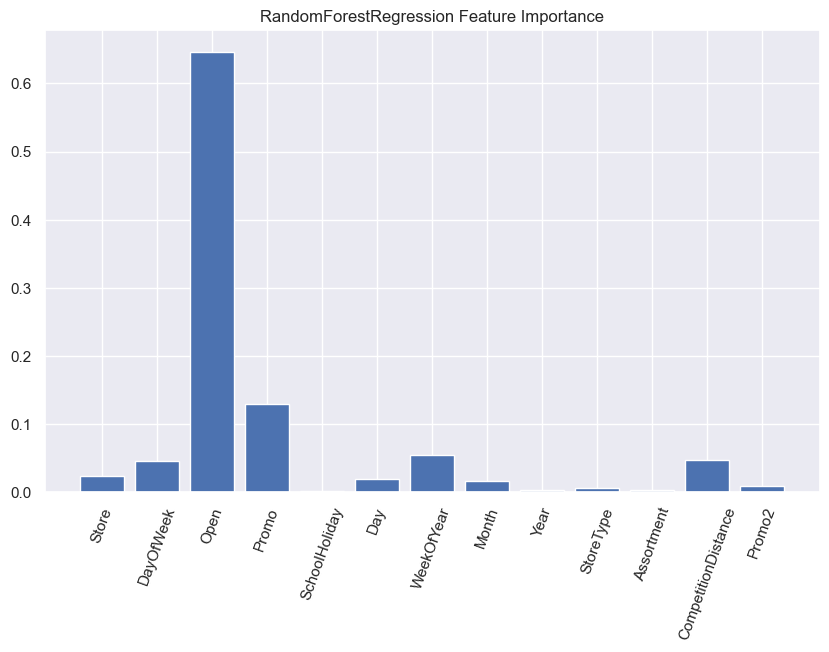

In [22]:
plt.figure(figsize=(10, 6))
important_features = rfr[1].feature_importances_
plt.bar(feature_columns, important_features)
plt.title('RandomForestRegression Feature Importance')
plt.xticks(rotation=70)
plt.show()

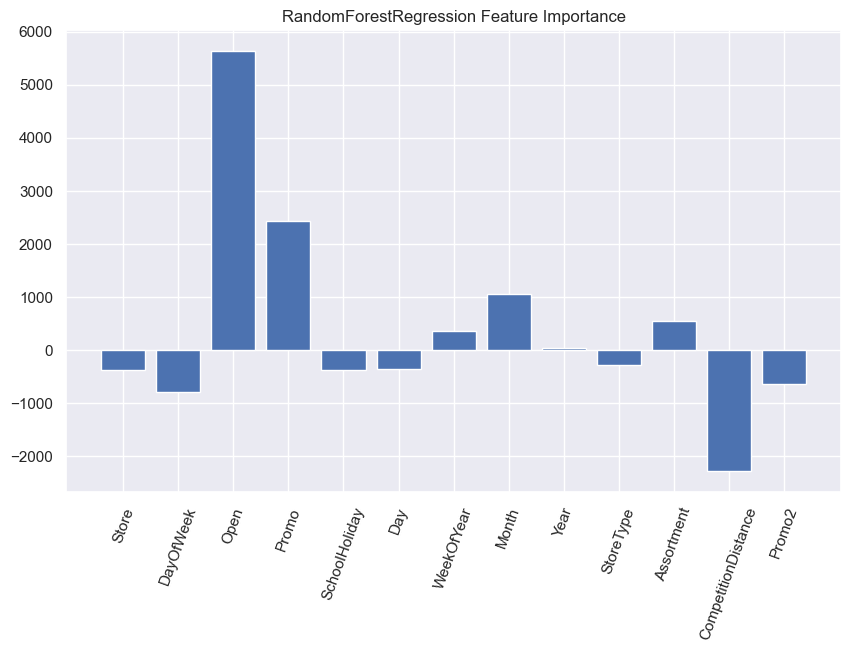

In [23]:
plt.figure(figsize=(10, 6))
important_features = lr[1].coef_[0]
plt.bar(feature_columns, important_features)
plt.title('RandomForestRegression Feature Importance')
plt.xticks(rotation=70)
plt.show()

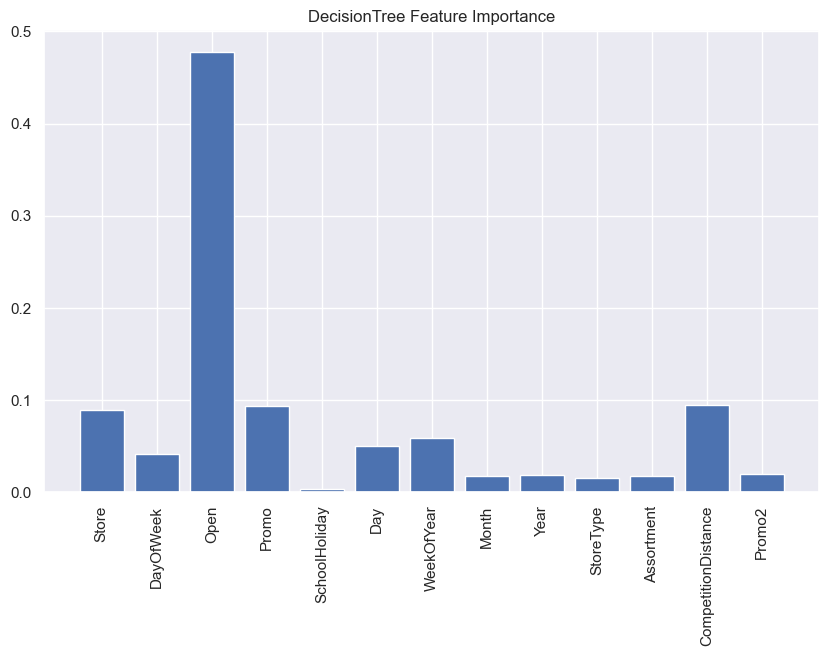

In [24]:
plt.figure(figsize=(10, 6))
important_features = dt[1].feature_importances_
plt.bar(feature_columns, important_features)
plt.title('DecisionTree Feature Importance')
plt.xticks(rotation=90)
plt.show()

## Serialize models

In [25]:
from time import gmtime, strftime

now = datetime.now()
time = now.strftime("%d-%m-%Y-%H-%M-%S-%f")[:-3]  # Remove microseconds
models_directory = 'models'
reg_model_file_name = f'models/reg-{time}.pkl'
lr_model_file_name = f'models/lr-{time}.pkl'
dt_model_file_name = f'models/dt-{time}.pkl'

files = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

## Create the models directory if it doesn't exist
os.makedirs(models_directory, exist_ok=True)

print(reg_model_file_name)

for i in range(len(files)):
    pickle.dump(models[i], open(files[i], 'wb'))

models/reg-05-01-2024-21-53-25-167.pkl


In [ ]:
### Add the mlflow here

In [26]:
reg_file = 'models/reg-05-01-2024-21-53-25-167.pkl'
lr_file = 'models/lr-05-01-2024-21-53-25-167.pkl'
dt_file = 'models/dt-05-01-2024-21-47-38-226.pkl'

reg_model = pickle.load(open(reg_file, 'rb'))
lr_model = pickle.load(open(lr_file, 'rb'))
dt_model = pickle.load(open(dt_file, 'rb'))

In [27]:
dt_score = dt_model.score(X_test, y_test)
dt_score

0.2647397933197241

In [28]:
lr_score = lr_model.score(X_test, y_test)
lr_score

0.5884483325533649

In [29]:
rfr_score = reg_model.score(X_test, y_test)
rfr_score

0.6123515101386496